In [1]:
import numpy as np
import jax_tqdm as jtqdm
import jax.numpy as jnp
from jax import jit, vmap, grad
import jax.lax as lax
import jax.scipy.stats as stats
import blackjax
import matplotlib.pyplot as plt
import time
import pickle
import numpyro, jax
import numpyro.distributions as dists
from numpyro.infer.util import initialize_model
from glob import glob
from astropy.io import fits

import WR_Geom_Model as gm
import WR_binaries as wrb

In [2]:
def gaussian_prior(value, mu, sigma):
    '''https://stackoverflow.com/questions/49810234/using-emcee-with-gaussian-priors'''
    return np.log(1.0 / (np.sqrt(2 * np.pi) * sigma)) - 0.5 * (value - mu)**2 / sigma**2
def flat_prior(value, a, b):
    if a < value < b:
        return 0.
    return -np.inf

In [3]:
system = wrb.apep.copy()

### --- INFERENCE --- ###  
# n = 256     # standard
n = 600     # VISIR
# n = 898     # JWST
@jit
def smooth_histogram2d(particles, weights, stardata):
    im_size = n
    
    x = particles[0, :]
    y = particles[1, :]
    
    xbound, ybound = jnp.max(jnp.abs(x)), jnp.max(jnp.abs(y))
    bound = jnp.max(jnp.array([xbound, ybound])) * (1. + 2. / im_size)
    
    xedges, yedges = jnp.linspace(-bound, bound, im_size+1), jnp.linspace(-bound, bound, im_size+1)
    return gm.smooth_histogram2d_base(particles, weights, stardata, xedges, yedges, im_size)
@jit
def smooth_histogram2d_w_bins(particles, weights, stardata, xbins, ybins):
    im_size = n
    return gm.smooth_histogram2d_base(particles, weights, stardata, xbins, ybins, im_size)


pscale = 1000 * 23/512 # mas/pixel, (Yinuo's email said 45mas/px, but I think the FOV is 23x23 arcsec for a 512x512 image?)
vlt_years = [2016, 2017, 2018, 2024]
vlt_data = {}
directory = "Data\\VLT"
fnames = glob(directory + "\\*.fits")

for i, fname in enumerate(fnames):
    
    data = fits.open(fname)[0].data
    
    length = data.shape[0]
    
    X = jnp.linspace(-1., 1., length) * pscale * length/2 / 1000
    Y = X.copy()
    
    xs, ys = jnp.meshgrid(X, Y)
    
    data[280:320, 280:320] = 0.
    data = jnp.array(data)
    
    # data = data - jnp.median(data)
    data = data - jnp.percentile(data, 84)
    data = data/jnp.max(data)
    data = jnp.maximum(data, 0)
    vlt_data[vlt_years[i]] = jnp.abs(data)**0.5

xbins = X
ybins = Y
error = 0.02

vlt_data_flat = {year:vlt_data[year].flatten() for year in vlt_years}

In [4]:
priors = {"eccentricity":[system['eccentricity'], 0.05],
         "open_angle":[system['open_angle'] - 20, system['open_angle'] + 20]}

In [11]:
def lnprior(theta):
    eccentricity, open_angle = theta
#     #flat priors on b, c
#     if not 1.0 < b < 2.0 and 1.0 < c < 2.0:
#         return -np.inf
    #gaussian prior on eccentricity
    eccen_prior = gaussian_prior(eccentricity, priors['eccentricity'][0], priors['eccentricity'][1])
    OA_prior = flat_prior(open_angle, priors['open_angle'][0], priors['open_angle'][1])
    
    return eccen_prior + OA_prior

In [12]:
def log_prob(theta):
    prior = lnprior(theta)
    if not np.isfinite(prior):
        return -np.inf
    
    eccentricity, open_angle = theta
    params = system.copy()
    params['eccentricity'] = eccentricity
    params['open_angle'] = open_angle
    
    chi_sq = 0
        
    for year in vlt_years:
        year_params = params.copy()
        year_params['phase'] -= (2024 - year) / params['period']
        samp_particles, samp_weights = gm.dust_plume(year_params)
        _, _, samp_H = smooth_histogram2d_w_bins(samp_particles, samp_weights, year_params, xbins, ybins)
        # samp_H = gm.add_stars(xbins, ybins, samp_H, year_params)
        samp_H.at[280:320, 280:320].set(0.)
        samp_H = samp_H.flatten()
        # samp_H = jnp.nan_to_num(samp_H, 1e4)
        
        chi_sq += -0.5 * np.sum((samp_H - vlt_data_flat[year])**2 / error**2)
    
    return prior + chi_sq

In [14]:
import emcee

nwalkers = 4
ndim = 2
nsteps = 300

initial = np.array([system['eccentricity'],
                   system['open_angle']])


pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob
)
sampler.run_mcmc(pos, 300, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [06:44<00:00,  1.35s/it]


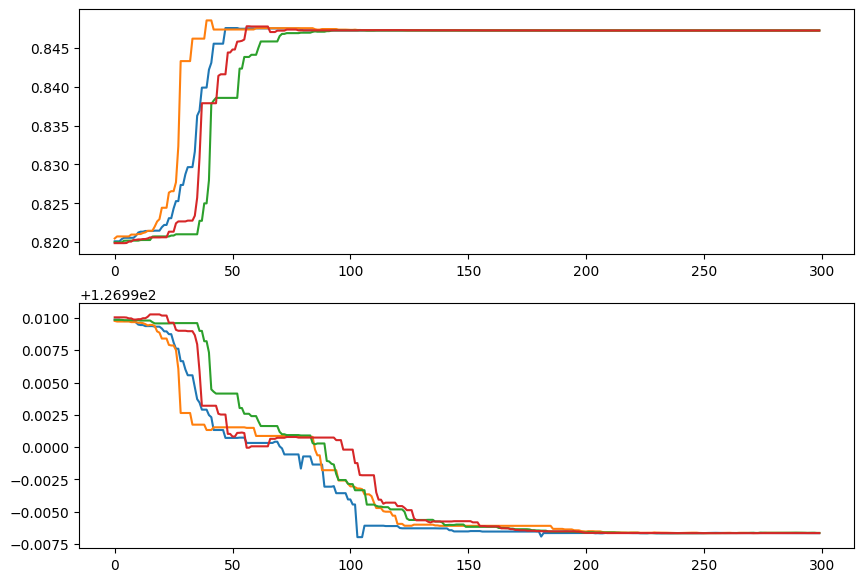

In [20]:
fig, axes = plt.subplots(nrows=ndim, figsize=(10, 7))
samples = sampler.get_chain()
# samples.shape
labels = ["e", "oa"]
for n in range(ndim):
    ax = axes[n]
    for i in range(nwalkers):
        ax.plot(samples[:, i, n])

In [19]:
tau = sampler.get_autocorr_time(discard=100)
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [25.20580793 22.96222953]

In [21]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.417


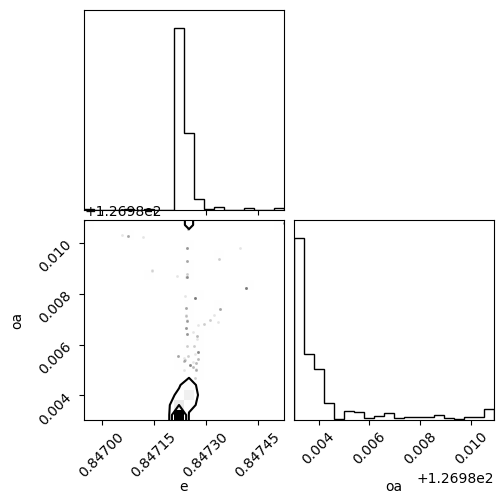

In [18]:
import corner

flat_samples = sampler.get_chain(discard=80, flat=True)

fig = corner.corner(
    flat_samples, labels=labels
);